# Immigration Behavior Analysis
#### Project Summary
The purpose of this project is to build an `auto-pipeline` to generate appropriate `Data Lake` on the `AWS` for immigration data. Nowadays, more and more people
are considering to immigrate to other countries for many reasons, including but not limit to escape conflict, seek suprior healthcare, education purpose, and 
etc. Thus, it is meaningful to analyze and understand what jobs those immigrants did before immigration, where they used to live, and how they arrive 
the countries. There are many more questions we could figure out by utlizing those immigration related dataset. Since the data provided here is specific used
for the United State, we would focus on analyzing immigration issues at the United State.

#### The project follows the follow steps:
* *Step 1*: Scope the Project and Gather Data
* *Step 2*: Explore and Assess the Data
* *Step 3*: Define the Data Model
* *Step 4*: Run ETL to Model the Data
* *Step 5*: Complete Project Write Up

In [270]:
# Do all imports and installs here
import pandas as pd
import os
import boto3
from pyspark.sql.functions import udf, col, desc, hour, year
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
plt.style.use('ggplot')

In [74]:
from pyspark.sql import SparkSession

# Create spark
spark = SparkSession.builder\
    .config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11")\
    .enableHiveSupport()\
    .getOrCreate()

## Step 1: Scope the Project and Gather Data
Two parts including `Scope` and `Describe & Gather Data` 
- Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>
- Describe the data sets you're using. Where did it come from? What type of information is included? 

### Data Sources
There are totally four datasets. Please find out the original data structures before ETL processes below:
1. Immigration Data
2. Airport Codes Data
3. US Cities Demographics Data
4. Global Land Temperature Data

In [81]:
# For immigration data
immigration_df = spark.read.parquet('sas_data')
# Columns and their corresponding types
immigration_df.printSchema()
print(f'Total numbers of row for Immigration Dataframe is {immigration_df.count()}')

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [119]:
immigration_df.limit(3).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,...,None,M,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,...,None,M,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,...,None,M,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1


In [82]:
# For airport codes csv
airport_df = spark.read.format("csv")\
    .option("header", "true")\
    .load("airport-codes_csv.csv")
airport_df.printSchema()
print(f'Total numbers of row for Airport Code Dataframe is {airport_df.count()}')

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)

Total numbers of row for Airport Code Dataframe is 55075


In [120]:
airport_df.limit(3).toPandas()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"


In [87]:
# For us cities demographics csv
demography_df = spark.read.format("csv")\
    .option("header", "true")\
    .option("delimiter", ";")\
    .load("us-cities-demographics.csv")
demography_df.printSchema()
print(f'Total numbers of row for Airport Code Dataframe is {demography_df.count()}')

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)

Total numbers of row for Airport Code Dataframe is 2891


In [121]:
demography_df.limit(3).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759


In [258]:
# For gobal land temperature by city csv
temperature_df = spark.read.format("csv")\
    .option("header", "true")\
    .load("GlobalLandTemperaturesByCity.csv")
temperature_df.printSchema()
print(f'Total numbers of row for Airport Code Dataframe is {temperature_df.count()}')

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: string (nullable = true)
 |-- AverageTemperatureUncertainty: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)

Total numbers of row for Airport Code Dataframe is 8599212


In [122]:
temperature_df.limit(3).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.7369999999999999,Århus,Denmark,57.05N,10.33E
1,1743-12-01,None,None,Århus,Denmark,57.05N,10.33E
2,1744-01-01,None,None,Århus,Denmark,57.05N,10.33E


### Step 2: Explore and Assess the Data
Two parts including `Explore the Data` and `Cleaning Steps`
- Identify data quality issues, like missing values, duplicate data, etc.
- Document steps necessary to clean the data

#### Plot below showing us what airlines those immigrants would take to arrive the U.S.
Since we have both immigration and airport dataset, we could briefly look at airport information on the dataset.
> There is one label on the y axis is missing, which is `None` because the organization does not know how these immigrants arrived.

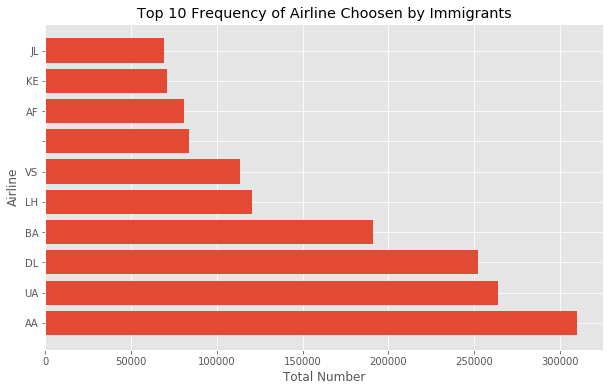

In [174]:
airline_frequency = immigration_df.groupBy('airline').count().orderBy(desc('count')).toPandas()

x = airline_frequency[:10]['airline'].tolist()
cnt = airline_frequency[:10]['count'].tolist()

x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize=(10,6))
plt.barh(x_pos, cnt)
plt.xlabel("Total Number")
plt.ylabel("Airline")
plt.title("Top 10 Frequency of Airline Choosen by Immigrants")

plt.yticks(x_pos, x)
plt.show()

#### However, there are no too much infomation in the airport dataset
1. First table shows numbers of airport at different states
2. Second table shows large airport details at California

In [193]:
airport_region = airport_df.where(col('iso_country') == 'US')\
    .groupBy('iso_region','iso_country').count().\
    orderBy(desc('count'))\
    .limit(10).toPandas()
airport_region

,iso_region,iso_country,count
0,US-TX,US,2277
1,US-CA,US,1088
2,US-FL,US,967
3,US-PA,US,918
4,US-IL,US,902
5,US-AK,US,829
6,US-OH,US,799
7,US-IN,US,697
8,US-NY,US,668
9,US-WI,US,624


In [200]:
airport_df.where((col('iso_region') == 'US-CA') & (col('type') == 'large_airport')).toPandas()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,KBAB,large_airport,Beale Air Force Base,113,NA,US,US-CA,Marysville,KBAB,BAB,BAB,"-121.43699646, 39.136100769"
1,KEDW,large_airport,Edwards Air Force Base,2312,NA,US,US-CA,Edwards,KEDW,EDW,EDW,"-117.884003, 34.905399"
2,KLAX,large_airport,Los Angeles International Airport,125,NA,US,US-CA,Los Angeles,KLAX,LAX,LAX,"-118.4079971, 33.94250107"
3,KOAK,large_airport,Metropolitan Oakland International Airport,9,NA,US,US-CA,Oakland,KOAK,OAK,OAK,"-122.221001, 37.721298"
4,KONT,large_airport,Ontario International Airport,944,NA,US,US-CA,Ontario,KONT,ONT,ONT,"-117.60099792480469, 34.055999755859375"
5,KSAN,large_airport,San Diego International Airport,17,NA,US,US-CA,San Diego,KSAN,SAN,SAN,"-117.190002441, 32.7336006165"
6,KSFO,large_airport,San Francisco International Airport,13,NA,US,US-CA,San Francisco,KSFO,SFO,SFO,"-122.375, 37.61899948120117"
7,KSJC,large_airport,Norman Y. Mineta San Jose International Airport,62,NA,US,US-CA,San Jose,KSJC,SJC,SJC,"-121.929001, 37.362598"
8,KSMF,large_airport,Sacramento International Airport,27,NA,US,US-CA,Sacramento,KSMF,SMF,SMF,"-121.59100341796875, 38.69540023803711"
9,KSNA,large_airport,John Wayne Airport-Orange County Airport,56,NA,US,US-CA,Santa Ana,KSNA,SNA,SNA,"-117.8679962, 33.67570114"


In [198]:
airport_df.groupBy('type').count().toPandas()

,type,count
0,large_airport,627
1,balloonport,24
2,seaplane_base,1016
3,heliport,11287
4,closed,3606
5,medium_airport,4550
6,small_airport,33965


#### For demography dataset, it's easier to see race distribution at different states
1. First table shows the population number depend on states and races, which is order by total numbers
2. The pie chart shows race distribution at California. It is worth to mention because there are large number of immigrants here.

In [235]:
sum_race_state_df = demography_df.groupBy('State Code', 'Race')\
    .agg(F.sum('Count').alias('Total'))\
    .orderBy(desc('Total')).toPandas()
sum_race_state_df.head(10)

,State Code,Race,Total
0,CA,White,14905129.0
1,TX,White,10508923.0
2,CA,Hispanic or Latino,9856464.0
3,TX,Hispanic or Latino,6311431.0
4,FL,White,4758144.0
5,NY,White,4555686.0
6,CA,Asian,4543730.0
7,AZ,White,3591611.0
8,NY,Hispanic or Latino,2730185.0
9,IL,White,2620068.0


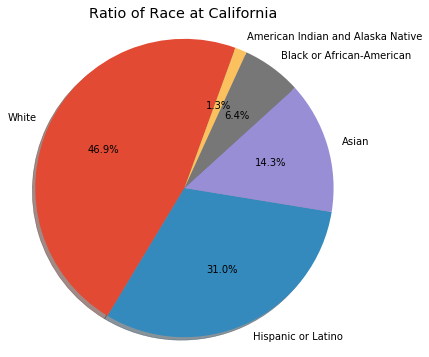

In [234]:
california_race = sum_race_state_df[sum_race_state_df['State Code'] == 'CA']

labels = california_race['Race']
sizes = california_race['Total']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=70)
plt.title('Ratio of Race at California')
plt.axis('equal')

plt.show()

#### For analyzing immigrantion at United States, we shoule set correct `Country`
- As there is a datetime columns, we could get specific year and month
- The line plot show temperature changes throughout the year at the city of Boston

In [266]:
avg_boston_temperaturenction to transform datetime
get_datetime = udf(lambda dt: str(datetime.strptime(dt, '%Y-%m-%d')))

# Transform dt to datetime format
us_df = temperature_df.where((col('Country') == 'United States'))\
    .withColumn('datetime', get_datetime('dt'))
us_df.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,datetime
0,1820-01-01,2.1010000000000004,3.217,Abilene,United States,32.95N,100.53W,1820-01-01 00:00:00
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,1820-02-01 00:00:00
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,1820-03-01 00:00:00
3,1820-04-01,17.988999999999994,2.202,Abilene,United States,32.95N,100.53W,1820-04-01 00:00:00
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,1820-05-01 00:00:00


In [277]:
# extract year from datetime
us_df = us_df.withColumn('year', year('datetime'))

avg_boston_temperature = us_df.select('AverageTemperature', 'City', 'year')\
    .where(col('City') == 'Boston')\
    .groupBy('year', 'City')\
    .agg(F.avg('AverageTemperature').alias('avg_temperature'))\
    .orderBy('year').toPandas()

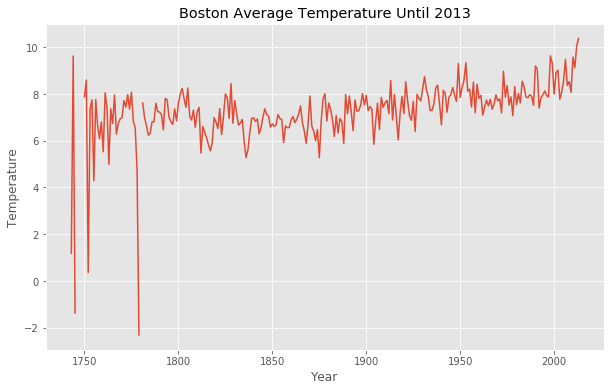

In [293]:
plt.figure(figsize=(10,6))

plt.plot(avg_boston_temperature['year'], avg_boston_temperature['avg_temperature'])
plt.ylabel('Temperature')
plt.xlabel('Year')
plt.title('Boston Average Temperature Until 2013')

plt.show()

### Step 3: Define the Data Model
For the data model, there are two main sections `Conceptual Data Model` and `Mapping Out Data Pipelines`:
- Map out the conceptual data model and explain why you chose that model
- List the steps necessary to pipeline the data into the chosen data model

From the **previous analysis**, we could figure out that if we want to analyze and finally approach our results is not that convenient. Therefore,
we really should build an **appropriate** data pipeline to process those data into a data lake so that any teams or researchers could use those information easily. 

To generate data pipeline, firstly we need to dicide what data models is most fitted. Given the data
source above, we should use `Star Schema` to build our data lake.



### Step 4: Run Pipelines to Model the Data 
There are basicly three parts to run the data pipeline:

`Create the Data Model` --> `Extract, Transform, and Load Data` --> `Data Quality Checks`

**Create the Data Model**
- Build the data pipelines to create the data model.

**Extract and Transform, and Load Data**

**Data Quality Checks**
- Integrity constraints on the relational database (e.g., unique key, data type, etc.)
- Unit tests for the scripts to ensure they are doing the right thing
- Source/Count checks to ensure completeness

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.